The goal of your analysis is to identify the most important features of houses that affect the sale prices.

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import pandas as pd
import numpy as np
from statsmodels.multivariate.pca import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Explore data and understand what the fields mean.

In [31]:
print(list(data.columns))

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

Examine the relationships between the sales price and other features in the dataset. 
Use data visualization techniques to help you gain intuitive understanding of the relationships.

In [7]:
data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [33]:
#SalePrice correlation to all variables:
print(data.corr().loc['SalePrice',:].sort_values())

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

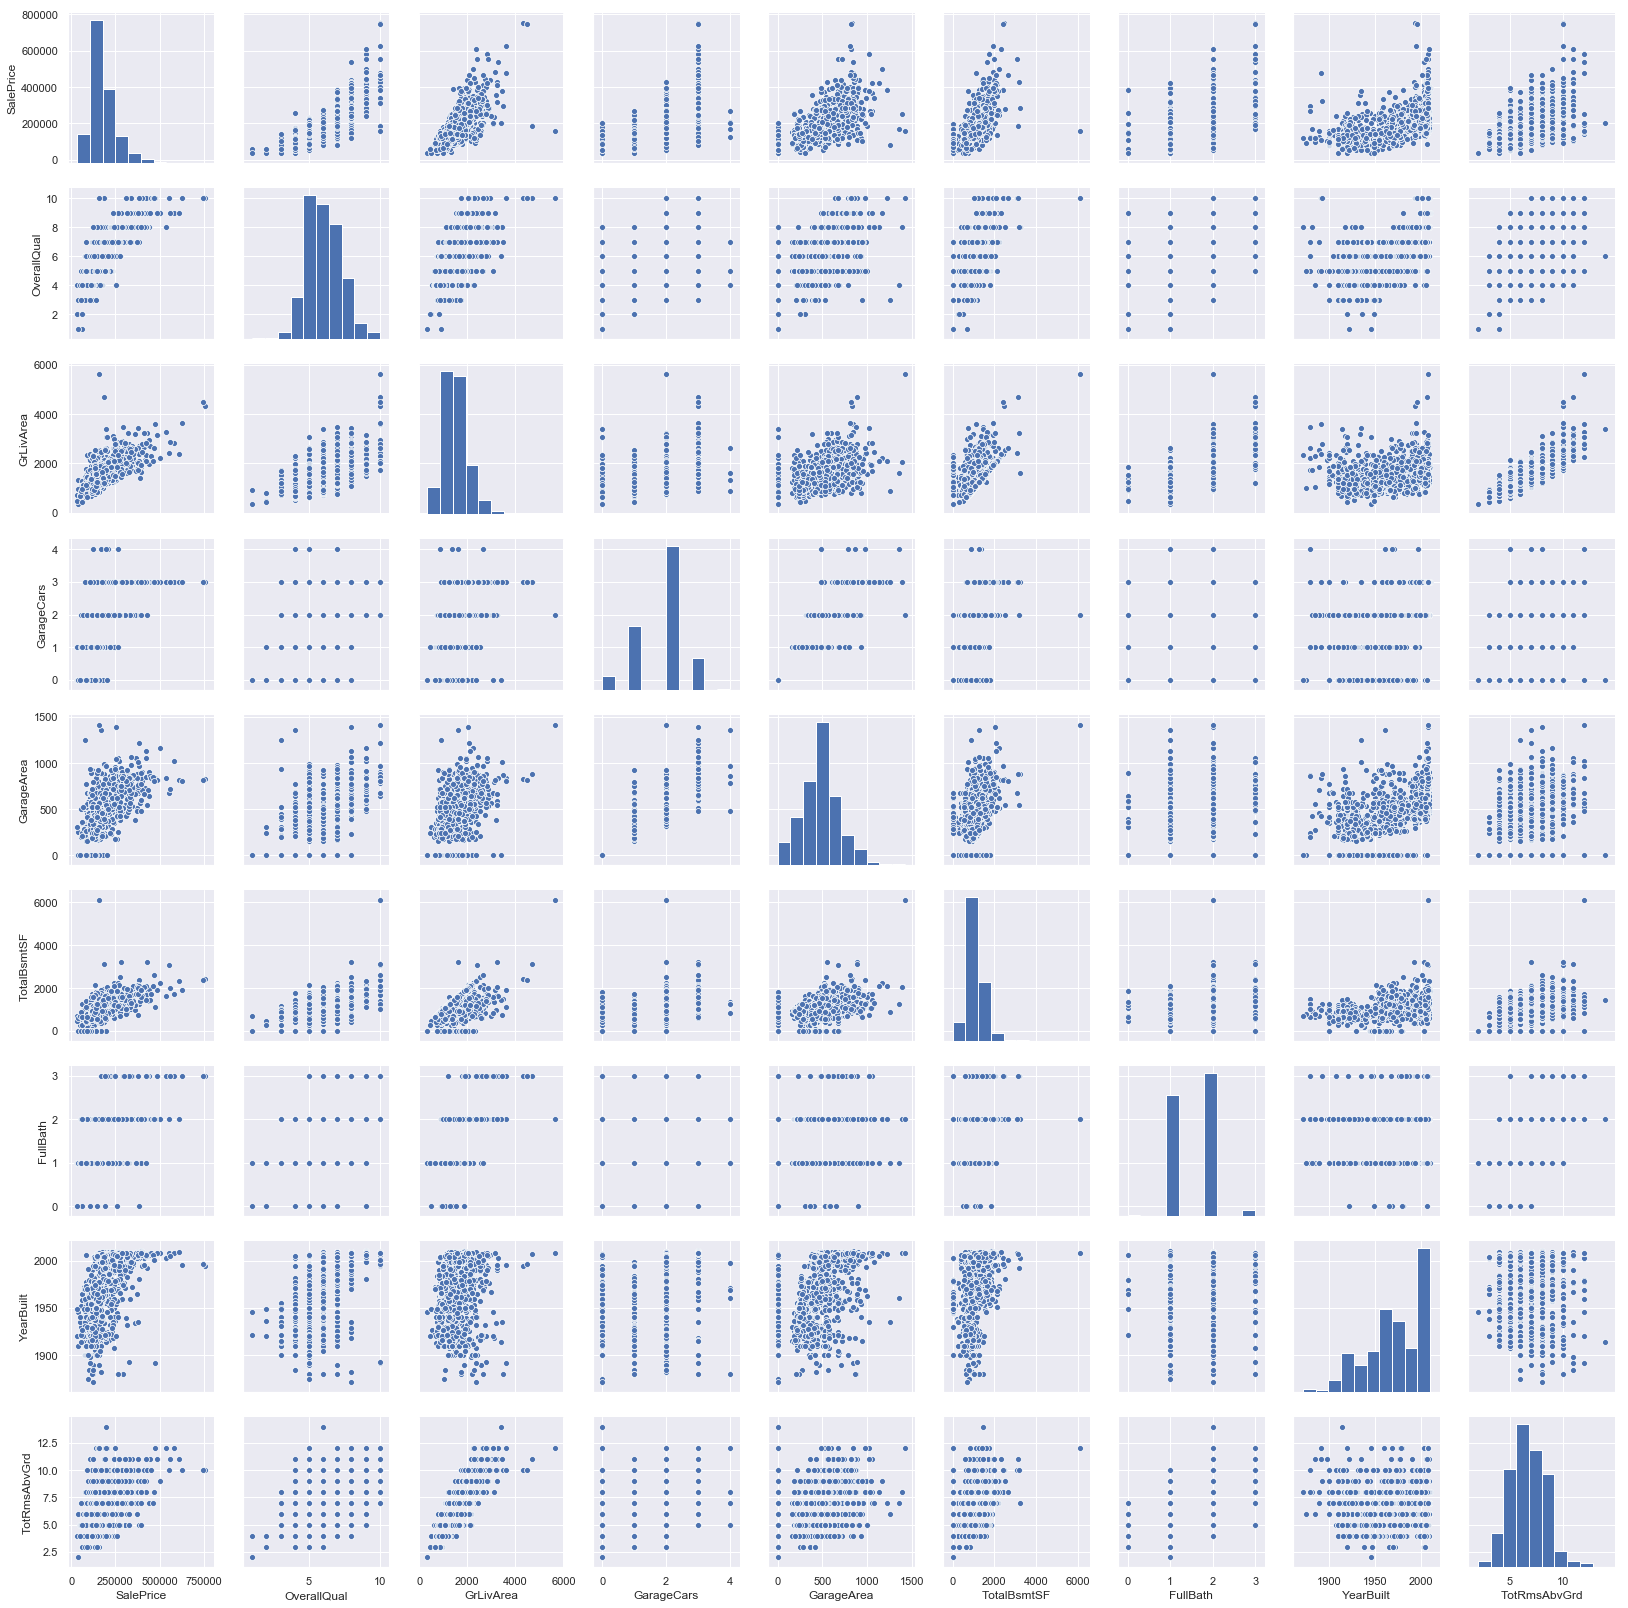

In [5]:
#scatterplot for selected columns (defined in cols)
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea' ,'TotalBsmtSF', 'FullBath', 'YearBuilt','TotRmsAbvGrd']
sns.pairplot(data[cols], height = 2.5)
plt.show()

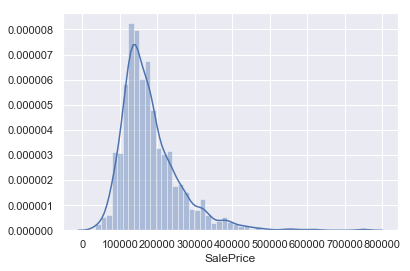

In [6]:
#Price distribution
sns.distplot(data.SalePrice)
plt.show ()

#It seems there is some skewness

In [8]:
stats.skew(data.SalePrice, axis=0, bias=True)

1.880940746034036

Make informed guess on which features should be investigated in depth.

We should investigate in depth:

    OverallQual
    GarageCars
    1stFlrSF
    YearBuilt

as they are the most correlated to our variable SalesPrice 
and we do not take all highly correlated parameters as they seems to be similar : 
GarageCars/GarageArea; 1stFlrSF/TotalBsmtSF

In [9]:
#Regression
X = sm.add_constant(data[['OverallQual', 'GarageCars', '1stFlrSF', 'YearBuilt']].values)

Y = data['SalePrice']

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     928.9
Date:                Mon, 23 Sep 2019   Prob (F-statistic):               0.00
Time:                        22:02:55   Log-Likelihood:                -17618.
No. Observations:                1460   AIC:                         3.525e+04
Df Residuals:                    1455   BIC:                         3.527e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.517e+05    8.9e+04     -3.953      0.0

Data cleaning & manipulation. Apply the following techniques as appropriate:

    Adjust skewed data distribution.
    Remove columns with high proportion of missing values.
    Remove records with missing values.
    Feature reduction.
    Convert categorical data to numerical.

In [10]:
null_cols = data.isnull().sum()
null_cols[null_cols>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [11]:
#drop Alley, PoolQC, Fence, MiscFeature columns, too much missing values
data.drop(columns=['Alley','PoolQC','Fence','MiscFeature'], inplace=True)

#It seems to have 81 houses without garages

In [ ]:
#Remove rows with at least 77-75 non-NA values.
#data.dropna(thresh=75)

Remove/take care of missing values

In [13]:
#data.LotFrontage: remplacer NaN par median
data.LotFrontage.fillna(data.LotFrontage.median(), inplace=True)

#does not work as it is an object
#data.Electrical.fillna(data.Electrical.mode(), inplace=True)

#data.MasVnrArea: remplacer NaN par
data.MasVnrArea.fillna(data.MasVnrArea.median(), inplace=True)

#data.GarageYrBlt: remplacer NaN par
data.GarageYrBlt.fillna(data.GarageYrBlt.median(), inplace=True)

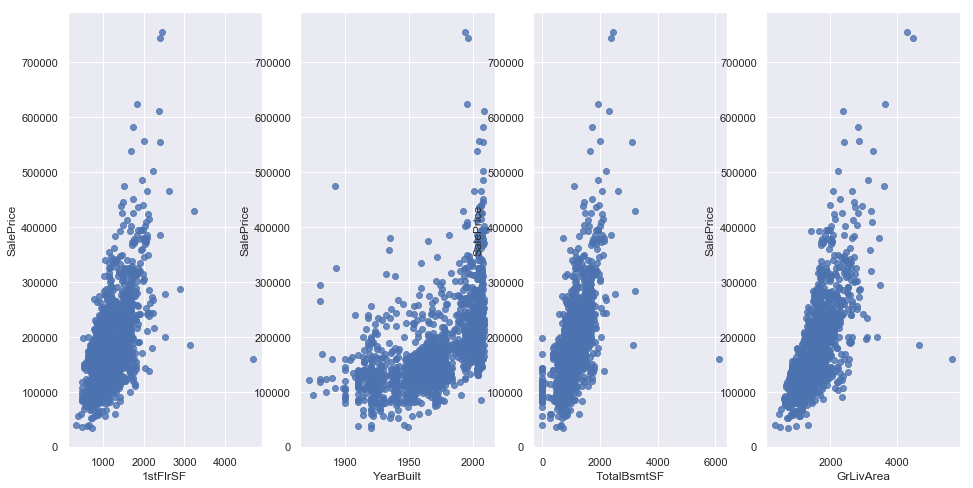

In [12]:
cols=['1stFlrSF', 'YearBuilt','TotalBsmtSF','GrLivArea','SalePrice']
df=data[cols]
fig,axes = plt.subplots(figsize = (16,8), nrows = 1, ncols = 4)
for i in range(4):
    plt.sca(axes[i])
    plt.scatter(df.iloc[:,i],df['SalePrice'], alpha = 0.8)
    plt.xlabel(df.iloc[:,i].name)
    plt.ylabel('SalePrice')

In [14]:
'''
OUTLIERS
1stFlrSF: remove value above 4000
TotalBsmtSF: remove value above 4000
GrLivArea: remove value above 4000
'''

data = data[(data['1stFlrSF']<4000) & (data['TotalBsmtSF']<4000) & (data['GrLivArea']<4000)]

In [15]:
null_cols = data.isnull().sum()
null_cols[null_cols>0]

MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [16]:
#Convertion of categorical data
data = pd.get_dummies(data)

In [17]:
null_cols = data.isnull().sum()
null_cols[null_cols>0]

#no more missing data, we can undertake a standardization

Series([], dtype: int64)

In [18]:
#Standardization
def standardize(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return (x - mean) / std
#convert categorical data before standardization
standardized=standardize(data)
standardized

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-1.729139,0.073476,-0.218699,-0.202770,0.665646,-0.517461,1.053769,0.880629,0.533895,0.625446,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
1,-1.726767,-0.871172,0.499122,-0.086107,-0.064709,2.176545,0.159469,-0.427190,-0.573757,1.257846,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
2,-1.724395,0.073476,-0.075135,0.081281,0.665646,-0.517461,0.987524,0.832191,0.341751,0.113946,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
3,-1.722023,0.309638,-0.457972,-0.091179,0.665646,-0.517461,-1.860986,-0.717817,-0.573757,-0.513805,...,-0.058702,-0.299700,-0.045439,0.388572,3.682391,-0.052486,-0.091161,-0.118015,-2.149796,-0.303765
4,-1.719651,0.073476,0.690541,0.386636,1.396000,-0.517461,0.954402,0.735316,1.404192,0.506871,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
5,-1.717279,-0.162686,0.738396,0.371926,-0.795063,-0.517461,0.722547,0.493127,-0.573757,0.685896,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
6,-1.714907,-0.871172,0.259849,-0.037006,1.396000,-0.517461,1.086891,0.977505,0.477382,2.166922,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
7,-1.712535,0.073476,-0.027280,-0.006775,0.665646,0.380541,0.060102,-0.572504,0.782551,0.981171,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765
8,-1.710163,-0.162686,-0.888665,-0.439142,0.665646,-0.517461,-1.331031,-1.686572,-0.573757,-1.016005,...,-0.058702,-0.299700,-0.045439,0.388572,3.682391,-0.052486,-0.091161,-0.118015,-2.149796,-0.303765
9,-1.707791,3.143582,-0.936520,-0.307261,-0.795063,0.380541,-1.066053,-1.686572,-0.573757,0.962571,...,-0.058702,-0.299700,-0.045439,0.388572,-0.271563,-0.052486,-0.091161,-0.118015,0.465160,-0.303765


Present your findings in statistical summary and/or data visualizations.

In [25]:
pc = PCA(standardized, ncomp=2)
product=np.dot(standardized.T,pc.factors)

In [26]:
product

array([[-2.84940670e-01,  1.68309484e-01],
       [-1.10671049e+00, -1.18879250e+01],
       [ 9.79807819e+00,  8.00771122e+00],
       [ 4.76373338e+00,  1.04647220e+01],
       [ 3.04320130e+01, -5.34283715e+00],
       [-9.04413948e+00,  4.07127994e+00],
       [ 3.24852403e+01,  3.46593125e+00],
       [ 2.67736145e+01, -6.57638058e+00],
       [ 1.63748108e+01,  3.01203356e+00],
       [ 1.20122342e+01,  1.74305712e+01],
       [-2.71961778e+00,  1.31969683e+01],
       [ 1.00904325e+01, -1.34616785e+01],
       [ 2.22998390e+01,  8.92497794e+00],
       [ 1.90203874e+01,  1.11787613e+01],
       [ 6.83110385e+00, -1.58122347e+01],
       [-4.20637410e+00, -4.37644138e+00],
       [ 1.96599864e+01, -5.85352683e+00],
       [ 8.05593478e+00,  1.34644862e+01],
       [-1.64401925e+00,  6.25119105e+00],
       [ 2.33320311e+01, -8.38547170e+00],
       [ 1.07392219e+01, -4.35452231e+00],
       [ 1.94793730e+00, -2.47246468e+00],
       [-7.55531250e+00, -5.23588291e+00],
       [ 1.

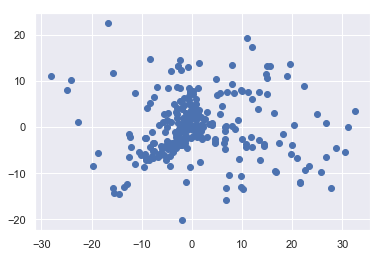

In [27]:
df_pca = pd.DataFrame(product, columns=['pc1','pc2'])
plt.scatter(df_pca.pc1,df_pca.pc2)